# Drawing ellipses for Stokes vectors

https://en.wikipedia.org/wiki/Stokes_parameters

Jones ellipses are deterministic and provides clear paths to the electric fields. However, Stokes vectors consider the unpolarized (aleatory) light. Here we modify the ellipses to determine the probability of the electric field

## Stokes vectors

In [1]:
%matplotlib notebook 
from py_pol import degrees, np
from py_pol.stokes import Stokes
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from numpy import sqrt, cos, sin

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

lim_min, lim_max = -1.5, 1.5

3.0.2


### Only 1 vector - no function

In [2]:
j0 = Stokes('j0')
j0.general_charac_angles(
    alpha=30*degrees, delay=90*degrees, intensity=1, pol_degree=0.95, is_depolarization=False)
j0.general_azimuth_ellipticity(azimuth=45*degrees, ellipticity=22.5*degrees,  intensity=1,  pol_degree=.95)
print(j0)

print(j0.parameters)

j0 = [+1.000; +0.000; +0.672; +0.672]

parameters of j0:
    intensity             : 1.000 arb. u.
    amplitudes            : E0x 0.689, E0y 0.689, E0_unpol 0.224 
    degree polarization   : 0.950
    degree linear pol.    : 0.672
    degree   circular pol.: 0.672
    alpha                 : 45.000º
    delay                 : 45.000º
    azimuth               : 45.000º
    ellipticity  angle    : 22.500º
    ellipticity  param    : 0.414
    eccentricity          : 0.910
    polarized vector      : [+0.950; +0.000; +0.672; +0.672]'
    unpolarized vector    : [+0.050; +0.000; +0.000; +0.000]'



In [3]:
parameters = j0.parameters.get_all()
print(parameters)

{'intensity': 1.0, 'amplitudes': (0.6892034376045111, 0.689203437604511, 0.22360679774997907), 'degree_pol': 0.95, 'degree_linear_pol': 0.6717514421272202, 'degree_circular_pol': 0.67175144212722, 'alpha': 0.7853981633974483, 'delay': 0.7853981633974482, 'ellipticity_param': 0.414213562373095, 'ellipticity_angle': 0.3926990816987241, 'azimuth': 0.7853981633974483, 'eccentricity': 0.9101797211244548, 'polarized': [0.95, 4.113291267118593e-17, 0.6717514421272202, 0.67175144212722], 'unpolarized': [0.050000000000000044, 0.0, 0.0, 0.0]}


### Get new parameters
TODO: Perhaps include in stokes.parameters.


In [4]:
polarized=parameters['polarized']
unpolarized = parameters['unpolarized']
s0_pol =polarized[0]
s0_unpol = unpolarized[0]
alpha=parameters['alpha']
delay=parameters['delay']+1e-6
u0_pol = np.sqrt(s0_pol)
u_unpol=np.sqrt(s0_unpol)

E0x = u0_pol * np.cos(alpha)+1e-10
E0y = u0_pol * np.sin(alpha)+1e-10
E0_unpol = u_unpol
# E0x^2+E0y^2=s0
# tan(alpha)=E0y/E0x
# E0x = cos(alpha) * sp.sqrt(s0)
# E0y = sin(alpha) * sp.sqrt(s0)
term1 = (1/E0x**2+1/E0y**2)
term2 = sqrt(((2*cos(delay)/(E0x*E0y))**2+(1/E0x**2-1/E0y**2)**2))
a2inv = (0.5/sin(delay)**2)*(term1+term2)
b2inv = (0.5/sin(delay)**2)*(term1-term2)

a = 1/sqrt(a2inv)             
b = 1/sqrt(b2inv)             

print(np.array((term1, term2, a2inv, b2inv)))
print(np.array((E0x, E0y, E0_unpol, alpha/degrees, a, b, delay/degrees)))

[4.2105 2.9773 7.1878 1.2332]
[ 0.6892  0.6892  0.2236 45.      0.373   0.9005 45.0001]


In [5]:
# New definition of a,b
# https://en.wikipedia.org/wiki/Elliptical_polarization



In [6]:
angles=np.linspace(0,360*degrees,256)

Ex = E0x*np.cos(angles)
Ey = E0y*np.cos(angles+delay)

E_unpolarized_x=E0_unpol*np.cos(angles)
E_unpolarized_y=E0_unpol*np.sin(angles)

radius_max, radius_min = np.sqrt((Ex**2+Ey**2).max()), np.sqrt((Ex**2+Ey**2).min())

print(radius_max, radius_min)



0.9004853098979106 0.3730133454775245


<IPython.core.display.Javascript object>


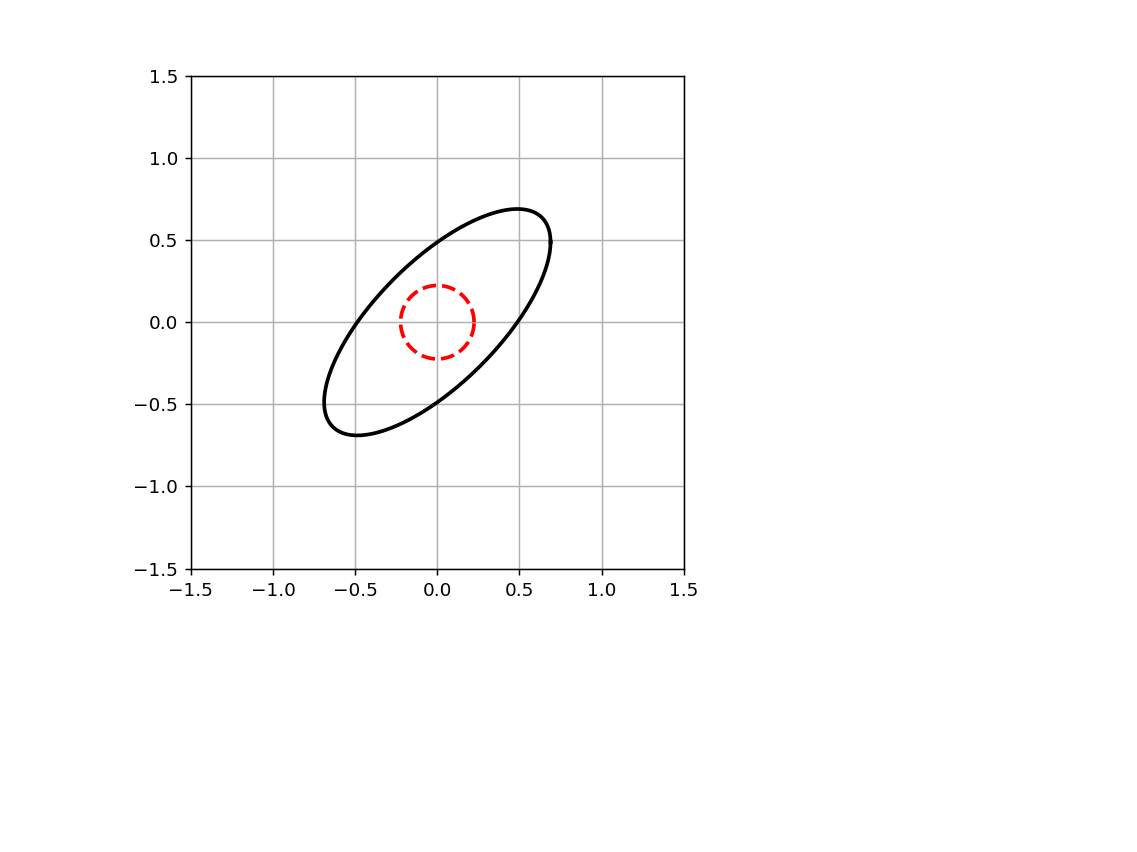

(-1.5, 1.5)

In [7]:
plt.figure()
plt.plot(Ex, Ey, 'k', lw=2)
plt.plot(E_unpolarized_x, E_unpolarized_y, 'r--', lw=2)
plt.axis('equal')
plt.axis('square')
plt.grid(True)
plt.xlim(lim_min, lim_max)
plt.ylim(lim_min, lim_max)

## Combinación de ambas para determinar la distribución de probabilidad

In [8]:
def draw2D(image,
           x,
           y,
           xlabel="$x  (\mu m)$",
           ylabel="$y  (\mu m)$",
           title="",
           color="hot"):  # YlGnBu  RdBu, jet, hot
    id_fig = plt.figure()
    IDax = id_fig.add_subplot(111)

    IDimage = plt.imshow(
        image,
        interpolation='bilinear',
        aspect='auto',
        origin='lower',
        extent=[x.min(), x.max(), y.min(), y.max()])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle(title)
    plt.colorbar()
    IDimage.set_cmap(color)
    return id_fig, IDax, IDimage



<IPython.core.display.Javascript object>


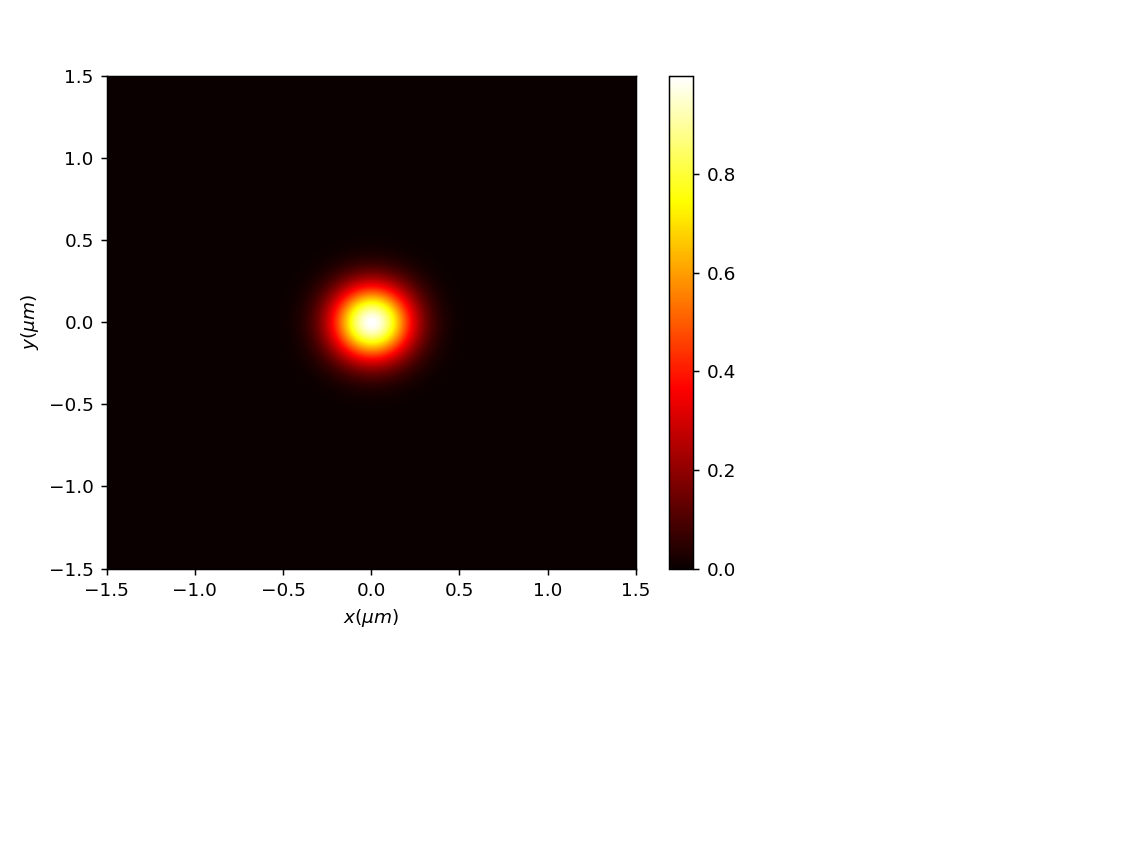

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fe07ac3dc88>)

In [9]:
x=np.linspace(lim_min, lim_max,256)
y=np.linspace(lim_min, lim_max, 256)

X,Y=np.meshgrid(x,y)

sigma=E0_unpol
ellipse_2D=np.zeros_like(X,dtype=float)

u_random=np.exp(-(X**2+Y**2)/(sigma**2))

draw2D(u_random, x, y)

In [11]:
def nearest2(vector, numero):
    """calcula la posocion de numero en ellipticity vector
        actualmente esta implementado para 1-D, pero habria que hacerlo para nD

        inputs:
        *vector es un array donde estan los points
        *numero es un array de los points que se quieren compute

        outputs:
        *imenor - orden del elemento
        *value  - value del elemento
        *distance - diferencia entre ellipticity value elegido y ellipticity incluido

        mejoras:
        *incluir n-dimensiones
    """
    indexes = np.abs(np.subtract.outer(vector, numero)).argmin(0)
    values = vector[indexes]
    distances = values - numero
    return indexes, values, distances


<IPython.core.display.Javascript object>


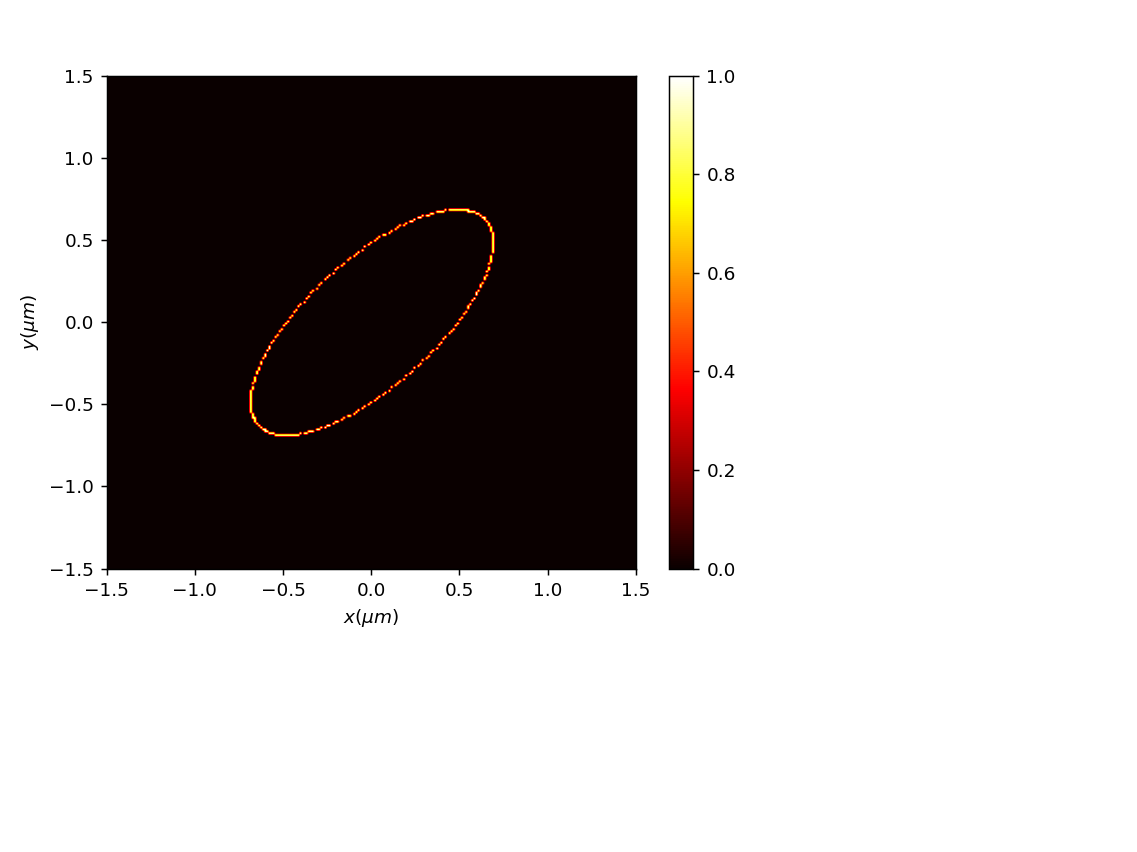

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fe07aa2d080>)

In [12]:

i_positions, _, _ = nearest2(x, Ex)
j_positions, _, _ = nearest2(y, Ey)
ellipse_2D[j_positions,i_positions] = 1

draw2D(ellipse_2D,x,y)



In [14]:

prob=fftconvolve(ellipse_2D, u_random, mode='same')
prob=prob/prob.max()

prob_high=np.zeros_like(X,dtype=float)
prob_high[prob>0.5]=1

<IPython.core.display.Javascript object>


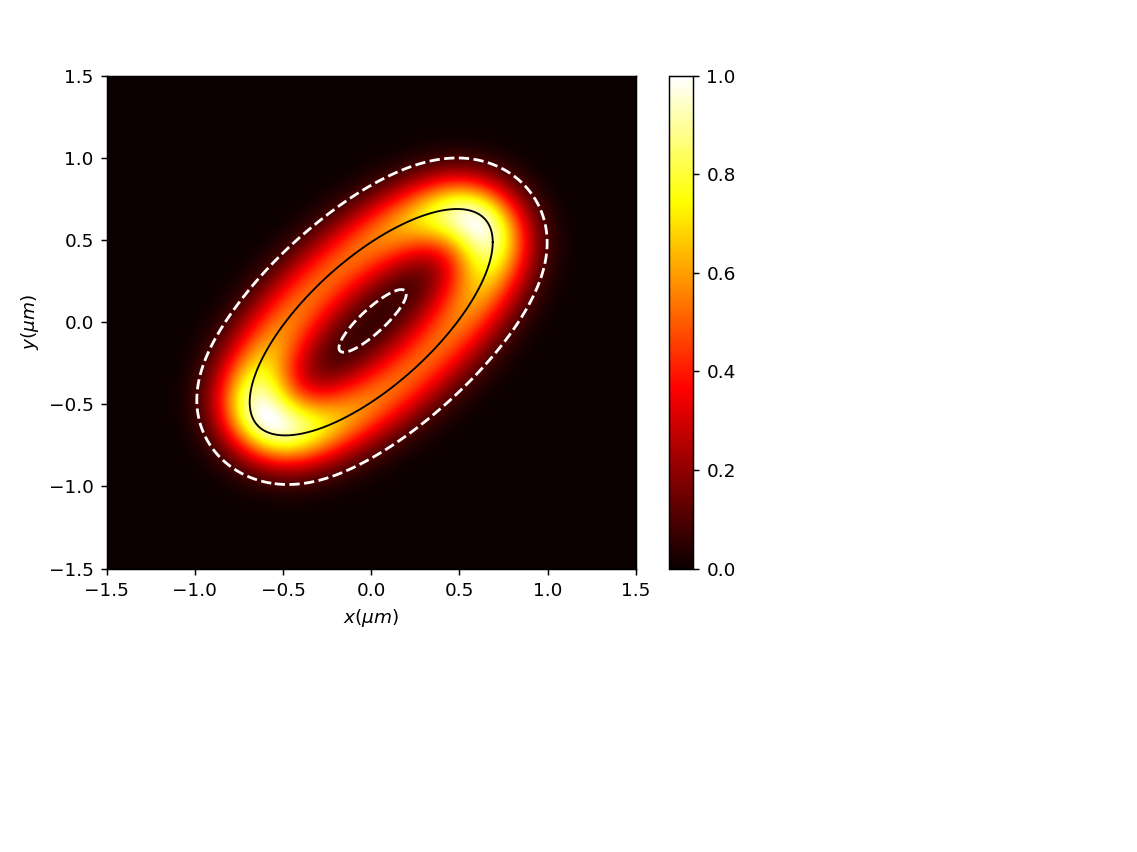

In [15]:
draw2D(prob,x,y)
plt.plot(Ex,Ey,'k',lw=1)
plt.contour(x,y,prob, (0.1,), colors=('w'), linestyles=('dashed'))

## Implemented in function

In [16]:
from py_pol.drawings import draw_ellipse_stokes

In [17]:
j0 = Stokes('j0')
j0.general_charac_angles(
    alpha=30*degrees, delay=90*degrees, intensity=1, pol_degree=0.95, is_depolarization=False)
j0.general_azimuth_ellipticity(azimuth=45*degrees, ellipticity=45*degrees,  intensity=1,  pol_degree=.9)
print(j0)

print(j0.parameters)

j0 = [+1.000; +0.000; +0.000; +0.900]

parameters of j0:
    intensity             : 1.000 arb. u.
    amplitudes            : E0x 0.671, E0y 0.671, E0_unpol 0.316 
    degree polarization   : 0.900
    degree linear pol.    : 0.000
    degree   circular pol.: 0.900
    alpha                 : 45.000º
    delay                 : 90.000º
    azimuth               : 45.000º
    ellipticity  angle    : 45.000º
    ellipticity  param    : 1.000
    eccentricity          : 0.000
    polarized vector      : [+0.900; +0.000; +0.000; +0.900]'
    unpolarized vector    : [+0.100; +0.000; +0.000; +0.000]'



<IPython.core.display.Javascript object>


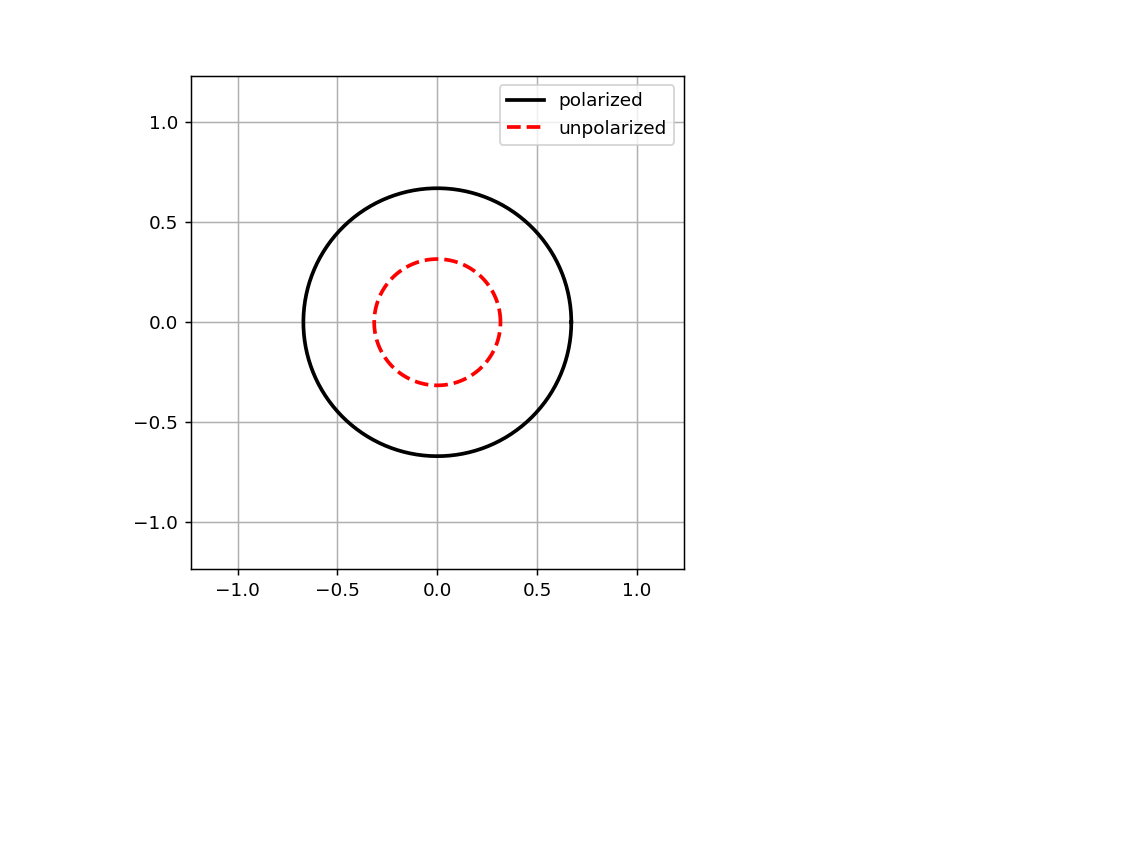

In [18]:
draw_ellipse_stokes(j0, kind='line', filename='trial.png')

<IPython.core.display.Javascript object>


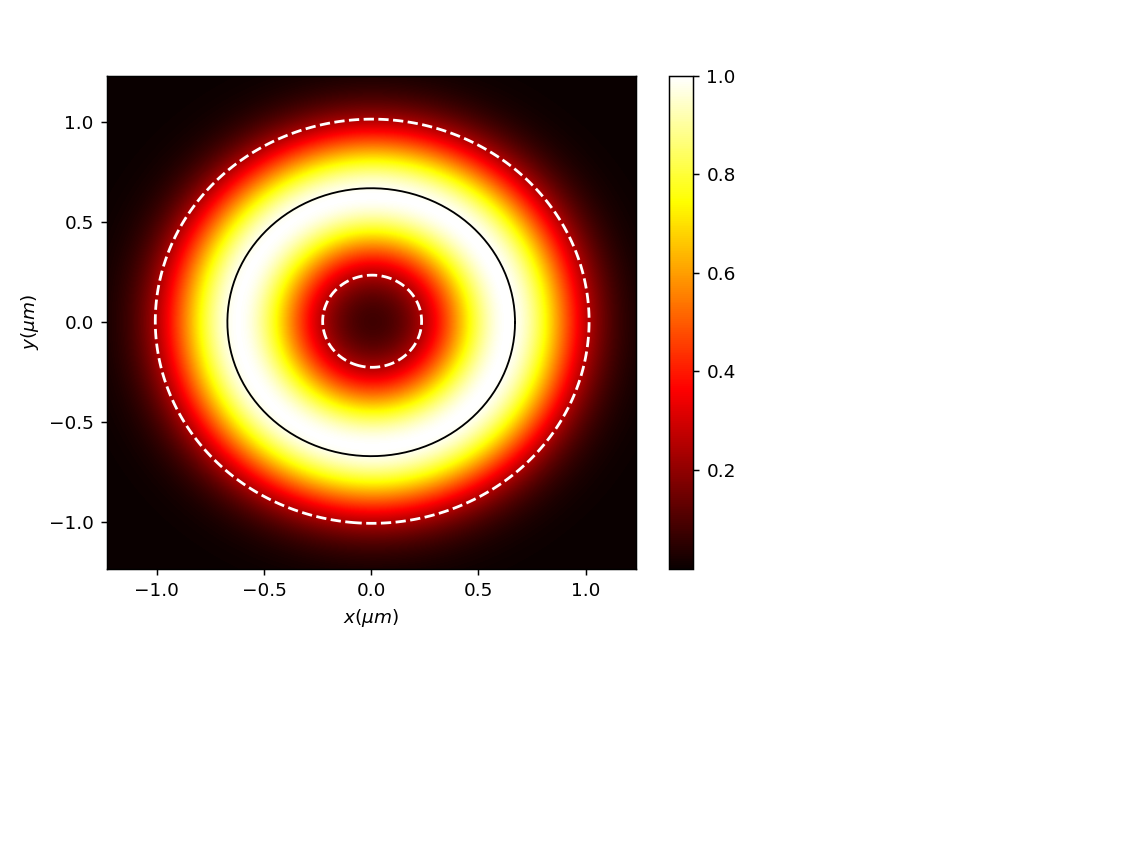

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe078fc8e80>,
 <Figure size 640x480 with 2 Axes>)

In [20]:
draw_ellipse_stokes(j0, kind='probabilities', filename='trial2.png', has_line=0.25)

<IPython.core.display.Javascript object>


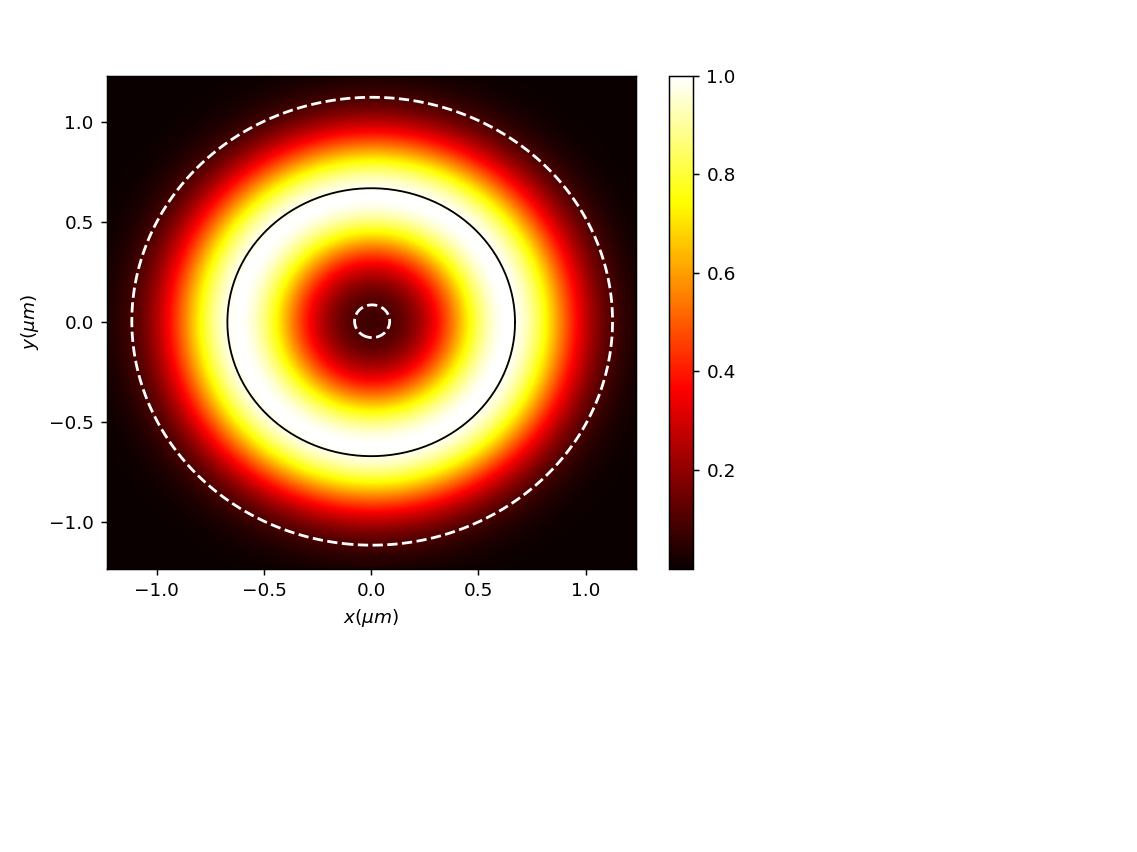

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe078f687b8>,
 <Figure size 640x480 with 2 Axes>)

In [21]:
j0.draw_ellipse()

In [ ]:
j0.draw_poincare()